<a href="https://colab.research.google.com/github/AlexH20/Supervised-ML-sentiment-measures/blob/main/Results_and_Descriptive_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptive statistics

In [1]:
%%capture
!pip install tabulate
!pip install pysentiment2
!pip install linearmodels
!pip install stargazer

import pandas as pd
pd.options.mode.chained_assignment = None 
import pysentiment2 as ps
from google.colab import drive 
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as md
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from sklearn.metrics import mean_squared_error

pd.set_option('display.expand_frame_repr', False)
drive.mount("/content/gdrive")

def count_words(Text):
    word_count = len(re.findall(r'\w+', Text))
    return word_count

#Function to split initial dataframe into dataframes grouped by year
def split_years(dt):
    dt["Year"] = dt["Date"].dt.year
    return [dt[dt["Year"] == y] for y in dt["Year"].unique()]

In [35]:
#Data raw
data = pd.read_csv("gdrive/My Drive/Thesis/processed data/processdata_woSWandPS.csv")
data["Date"] = pd.to_datetime(data["Date"], format = "%Y-%m-%d")
data["Word Count"] = [count_words(x) for x in data.Text]

#Data without sentiment measures
data_final = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR.csv")
data_final_ot = data_final[data_final.word_count != 0]
data_final_ot["Date"] = pd.to_datetime(data_final_ot["Date"], format = "%Y-%m-%d")

#Data DM methods
data_dm = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_dm.csv")
data_dm["Date"] = pd.to_datetime(data_dm["Date"], format = "%Y-%m-%d")
data_dm["Date"] = pd.to_datetime(data_dm["Date"])
data_dm["Year"] = [x.year for x in data_dm["Date"]]
data_dm["Month"] = [x.month for x in data_dm["Date"]]
data_dm["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_dm.iterrows()]
data_dm = data_dm[~data_dm["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_dm = data_dm.fillna(0)

#Data RF with one- and two-grams
data_rf_12 = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_RF12.csv", index_col = False)
data_rf_12["Date"] = pd.to_datetime(data_rf_12["Date"])
data_rf_12["Year"] = [x.year for x in data_rf_12["Date"]]
data_rf_12["Month"] = [x.month for x in data_rf_12["Date"]]
data_rf_12["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_rf_12.iterrows()]
data_rf_12 = data_rf_12[~data_rf_12["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_rf_12 = data_rf_12.fillna(0)

#Data RF with FinBERT as encoder
data_rf_Fin = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_RFFin.csv")
data_rf_Fin["Date"] = pd.to_datetime(data_rf_Fin["Date"])
data_rf_Fin["Year"] = [x.year for x in data_rf_Fin["Date"]]
data_rf_Fin["Month"] = [x.month for x in data_rf_Fin["Date"]]
data_rf_Fin["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_rf_Fin.iterrows()]
data_rf_Fin = data_rf_Fin[~data_rf_Fin["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_rf_Fin = data_rf_Fin.fillna(0)

#Data FinBERT as encoder + NN
data_Fin = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_FinNN.csv")
data_Fin["Date"] = pd.to_datetime(data_Fin["Date"])
data_Fin["Year"] = [x.year for x in data_Fin["Date"]]
data_Fin["Month"] = [x.month for x in data_Fin["Date"]]
data_Fin["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_Fin.iterrows()]
data_Fin = data_Fin[~data_Fin["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_Fin = data_Fin.fillna(0)

#Fama French Factors
data_ff = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/famafrenchfactors.csv")
data_ff["Date"] = pd.to_datetime(data_ff["date"], format = "%Y%m%d")
data_ff.drop("date", axis = 1, inplace = True)

#Merge every dataframe with sentiment measures
data_full = data_dm
data_full["abret RF12"] = data_rf_12["AR_RF"]
data_full["abret RFFin"] = data_rf_Fin["AR_RFFin"]
data_full["abret FinNN"] = data_Fin["AR_FinNN"]
data_full["ln(Size)"] = np.log(data_full["Size"])
data_full.rename({"Return":"ret", "AR": "abret", "HIV4_tone":"HIV4 Tone", "LM_tone":"LM Tone"}, axis = 1,inplace = True)
data_full = data_full.merge(data_ff, how= "left", left_on= ["Date"], right_on = ["Date"])
data_full["retrf"] = data_full["ret"] - data_full["rf"]

**Descriptive Statistics of raw dataset:**

In [28]:
data_splt_years = split_years(data)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["Word Count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data)
mean_word_count = round(data["Word Count"].mean(),0)
company_count = data["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))

+----+-----------+-----------------+-------------------+-----------------+
|    | Year      |   News Articles |   Mean Word Count |   Company Count |
|----+-----------+-----------------+-------------------+-----------------|
|  0 | 2009      |             111 |               849 |              70 |
|  1 | 2010      |            2792 |               434 |             865 |
|  2 | 2011      |            4277 |               460 |            1001 |
|  3 | 2012      |           10261 |               335 |            2279 |
|  4 | 2013      |           13143 |               275 |            3076 |
|  5 | 2014      |           26234 |               293 |            3997 |
|  6 | 2015      |           35458 |               344 |            4312 |
|  7 | 2016      |           36569 |               384 |            4261 |
|  8 | 2017      |           39630 |               479 |            4188 |
|  9 | 2018      |           77086 |               670 |            5195 |
| 10 | 2019      |       

**Extract Top 100 companies w.r.t news frequency in years 2015 till 2019:**

In [29]:
#Get top 120 companies with regards to news frequency (later only top 100, since some will be removed like SPX)

yearst = [2015, 2016, 2017, 2018, 2019]

data = data[data.Year.isin(yearst) == True]
unique_data_company =  data.groupby("Ticker").nunique()

unique_data_company.sort_values(by = "Text", ascending = False, inplace = True)

print(list(unique_data_company.index[0:120]))

['AAPL', 'AMZN', 'TSLA', 'FB', 'BA', 'NFLX', 'DIS', 'EFX', 'SPX', 'BAC', 'INTC', 'DAX', 'F', 'GLD', 'GE', 'GM', 'MSFT', 'SBUX', 'AIR', 'AAL', 'IBM', 'JPM', 'CMG', 'WFC', 'C', 'TWTR', 'WMT', 'MCD', 'AMD', 'NVDA', 'JNJ', 'GS', 'BABA', 'CAT', 'MU', 'CSCO', 'XOM', 'CVX', 'BP', 'GOOGL', 'USD', 'GPRO', 'COST', 'QQQ', 'HD', 'SQ', 'NKE', 'KO', 'TGT', 'AXP', 'ATVI', 'CMCSA', 'SNAP', 'DAL', 'LMT', 'T', 'ABBV', 'PFE', 'ADBE', 'GILD', 'CRM', 'VZ', 'AVGO', 'BX', 'LULU', 'BLK', 'FIT', 'KMI', 'BBY', 'UNH', 'AGI', 'AA', 'PG', 'AMAT', 'M', 'MRK', 'BIDU', 'QCOM', 'JCP', 'FDX', 'AMGN', 'BMY', 'ORCL', 'PYPL', 'BHP', 'MA', 'FRA', 'KR', 'SHOP', 'MO', 'PM', 'GME', 'CHK', 'VRX', 'ABX', 'MMM', 'COP', 'BBBY', 'UTX', 'IRBT', 'MS', 'SPY', 'FCX', 'HAL', 'AGN', 'UAL', 'HPQ', 'JWN', 'CVS', 'CELG', 'EA', 'STZ', 'V', 'APC', 'AZN', 'EBAY', 'ACN', 'ADP', 'GLW', 'PEP']


**Descriptive statistics of final dataset:**

In [30]:
#Descriptive statistics of final dataset 
data_splt_years = split_years(data_final_ot)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["word_count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data_final_ot)
mean_word_count = round(data_final_ot["word_count"].mean(),0)
company_count = data_final_ot["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles (post-merge)", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))

+----+-----------+------------------------------+-------------------+-----------------+
|    | Year      |   News Articles (post-merge) |   Mean Word Count |   Company Count |
|----+-----------+------------------------------+-------------------+-----------------|
|  0 | 2015      |                         4403 |               822 |             100 |
|  1 | 2016      |                         5415 |               839 |             100 |
|  2 | 2017      |                         5775 |               921 |             100 |
|  3 | 2018      |                         8516 |              1353 |             100 |
|  4 | 2019      |                         6476 |              1401 |             100 |
|  5 | All years |                        30585 |              1114 |             100 |
+----+-----------+------------------------------+-------------------+-----------------+


**Sample description variables:**

In [49]:
data_full_des = data_full[["ret", "rf", "mktrf", "smb", "hml", "Nasdaq", "Turnover", "Size", "BTM", "HIV4 Tone", "LM Tone", "abret", "abret RF12", "abret RFFin", "abret FinNN"]]
des_table = data_full_des.describe().loc[["mean", "std", "25%", "50%", "75%"]]
print(des_table.T)

                     mean           std           25%           50%           75%
ret          4.970856e-04  1.924447e-02 -7.437180e-03  6.473575e-04  8.803862e-03
rf           3.825848e-05  3.467147e-05  1.000000e-05  3.000000e-05  7.000000e-05
mktrf        4.082493e-04  8.662284e-03 -3.000000e-03  5.000000e-04  4.900000e-03
smb         -1.002750e-04  5.092307e-03 -3.400000e-03 -2.000000e-04  3.100000e-03
hml         -1.347388e-04  5.519331e-03 -3.600000e-03 -4.000000e-04  3.000000e-03
Nasdaq       4.653465e-01  4.988000e-01  0.000000e+00  0.000000e+00  1.000000e+00
Turnover     1.865919e+00  1.948006e+00  7.614874e-01  1.179941e+00  2.037917e+00
Size         1.142643e+08  1.318154e+08  2.762116e+07  7.524095e+07  1.629465e+08
BTM          5.253756e-01  1.569613e+00  1.234271e-01  2.570894e-01  4.910447e-01
HIV4 Tone    9.886655e-02  1.998711e-01  0.000000e+00  0.000000e+00  0.000000e+00
LM Tone     -1.339437e-02  2.352117e-01  0.000000e+00  0.000000e+00  0.000000e+00
abret        1.0

**Correlation Matrix of sentiment measures:**

In [37]:
data_full_cor = data_full[["HIV4 Tone", "LM Tone", "abret RF12", "abret RFFin", "abret FinNN"]]
corr_matrix = data_full_cor.corr()
print(corr_matrix)

             HIV4 Tone   LM Tone  abret RF12  abret RFFin  abret FinNN
HIV4 Tone     1.000000  0.159351    0.064661     0.025172    -0.269292
LM Tone       0.159351  1.000000    0.011613     0.001629    -0.002597
abret RF12    0.064661  0.011613    1.000000     0.005716    -0.016207
abret RFFin   0.025172  0.001629    0.005716     1.000000     0.005601
abret FinNN  -0.269292 -0.002597   -0.016207     0.005601     1.000000


**Dictionary Methods Comparison: AAPL 2015 Q2**

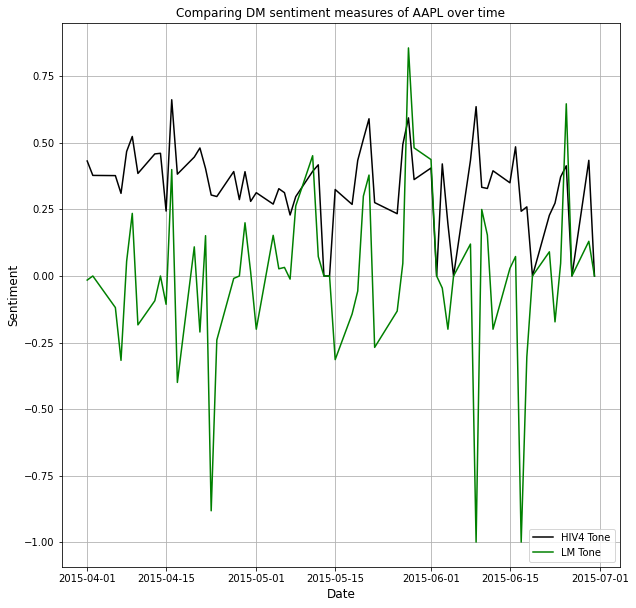

In [8]:
data_dm_aapl = data_full.loc[data_full["Ticker"].isin(["AAPL"])]
data_dm_aapl["Date"] = pd.to_datetime(data_dm_aapl["Date"], format = "%Y-%m-%d")
data_dm_aapl = data_dm_aapl[data_dm_aapl["ordered_month"].isin([4,5,6])]

sentiment_measures = ["HIV4 Tone", "LM Tone"]
colors = {"HIV4 Tone":"black", "LM Tone":"green"}

fig1, ax1 = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax1.plot(data_dm_aapl["Date"], data_dm_aapl[sentiment], c = colors[sentiment],label = sentiment)

plt.grid()
plt.title("Comparing DM sentiment measures of AAPL over time")
plt.xlabel("Date", size=12)
plt.ylabel("Sentiment", size=12)
plt.legend(loc = 4)

**Supervised Machine Learning Methods Comparison: AAPL 2015 Q2**

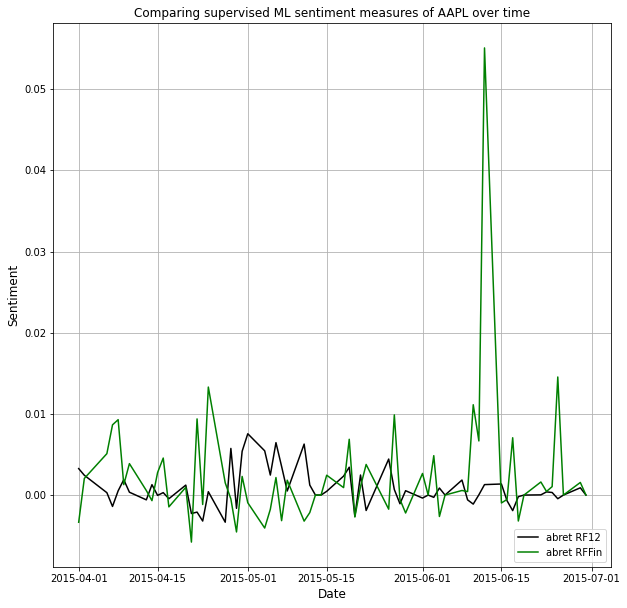

In [38]:
data_sml_aapl = data_full.loc[data_full["Ticker"].isin(["AAPL"])]
data_sml_aapl["Date"] = pd.to_datetime(data_sml_aapl["Date"], format = "%Y-%m-%d")
data_sml_aapl = data_sml_aapl[data_sml_aapl["ordered_month"].isin([4,5,6])]

sentiment_measures = ["abret RF12", "abret RFFin"]
colors = {"abret RF12":"black", "abret RFFin":"green"}

fig1, ax1 = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax1.plot(data_sml_aapl["Date"], data_sml_aapl[sentiment], c = colors[sentiment],label = sentiment)

plt.grid()
plt.title("Comparing supervised ML sentiment measures of AAPL over time")
plt.xlabel("Date", size=12)
plt.ylabel("Sentiment", size=12)
plt.legend(loc = 4)

**Mean Squared Error of Return Sentiment Measures:**

In [40]:
mse_rf12 = mean_squared_error(data_full["abret"], data_full["abret RF12"])
mse_rffin = mean_squared_error(data_full["abret"], data_full["abret RFFin"])
mse_finnn = mean_squared_error(data_full["abret"], data_full["abret FinNN"])
print("The MSE of RF with one- anf two-grams is: {}".format(mse_rf12))
print("The MSE of RF with FinBERT as encoder is: {}".format(mse_rffin))
print("The MSE FinBERT + NN is: {}".format(mse_finnn))

The MSE of RF with one- anf two-grams is: 0.0002927553027009357
The MSE of RF with FinBERT as encoder is: 0.0003032096436926174
The MSE FinBERT + NN is: 0.006359672600208324


**Results of panel data regression:**

In [41]:
#HIV dictionary 

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "HIV4 Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_hiv4 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_hiv4 = pooled_olsr_model_hiv4.fit()
print(pooled_olsr_model_results_hiv4.summary())


#LM dictionary

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "LM Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lm = pooled_olsr_model_lm.fit()
print(pooled_olsr_model_results_lm.summary())

#RF12

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret RF12"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rf12 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rf12 = pooled_olsr_model_rf12.fit()
print(pooled_olsr_model_results_rf12.summary())

#RF with FinBERT as encoder

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret RFFin"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rffin = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rffin = pooled_olsr_model_rffin.fit()
print(pooled_olsr_model_results_rffin.summary())

#FinBERT + NN

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret FinNN"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_finnn = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_finnn = pooled_olsr_model_finnn.fit()
print(pooled_olsr_model_results_finnn.summary())





                            OLS Regression Results                            
Dep. Variable:                  abret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.412
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           9.11e-07
Time:                        09:02:14   Log-Likelihood:             2.9266e+05
No. Observations:              110191   AIC:                        -5.853e+05
Df Residuals:                  110184   BIC:                        -5.852e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.616e-05      0.000     -0.647      0.5

**Results of FF3 regression:**

In [44]:
data_full["retrf"] = data_full["ret"] - data_full["rf"]

#HIV dictionary 


endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "HIV4 Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_hiv4 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_hiv4 = pooled_olsr_model_hiv4.fit()
print(pooled_olsr_model_results_hiv4.summary())


#LM dictionary

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "LM Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lm = pooled_olsr_model_lm.fit()
print(pooled_olsr_model_results_lm.summary())

#RF12

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret RF12"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rf12 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rf12 = pooled_olsr_model_rf12.fit()
print(pooled_olsr_model_results_rf12.summary())

#RF with FinBERT as encoder

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret RFFin"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rffin = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rffin = pooled_olsr_model_rffin.fit()
print(pooled_olsr_model_results_rffin.summary())

#FinBERT + NN

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret FinNN"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_finnn = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_finnn = pooled_olsr_model_finnn.fit()
print(pooled_olsr_model_results_finnn.summary())

                            OLS Regression Results                            
Dep. Variable:                  retrf   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     3979.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:04:58   Log-Likelihood:             2.9294e+05
No. Observations:              110191   AIC:                        -5.859e+05
Df Residuals:                  110182   BIC:                        -5.858e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -1.338      0.1

TypeError: ignored

**R-squared of FF3 models:**

In [48]:
print("R-squared of HIV4: {}".format(pooled_olsr_model_results_hiv4.rsquared))
print("R-squared of LM: {}".format(pooled_olsr_model_results_lm.rsquared))
print("R-squared of RF12: {}".format(pooled_olsr_model_results_rf12.rsquared))
print("R-squared of RFFin: {}".format(pooled_olsr_model_results_rffin.rsquared))
print("R-squared of FinNN: {}".format(pooled_olsr_model_results_finnn.rsquared))

R-squared of HIV4: 0.224139485630948
R-squared of LM: 0.22443119970801295
R-squared of RF12: 0.22411161777158994
R-squared of RFFin: 0.2240594455396151
R-squared of FinNN: 0.22399946613206845
